In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# .jsonlファイルを読み込む
with open('./docs/train900_pairs.jsonl', 'r') as f:
    data = f.readlines()

# json形式に変換
data = [json.loads(d) for d in data]


In [23]:
data[0].keys()

dict_keys(['class_id', 'class_name', 'samples', 'neighbors'])

['train/n02119789/n02119789_9474.JPEG', 'train/n02119789/n02119789_10546.JPEG', 'train/n02119789/n02119789_11670.JPEG', 'train/n02119789/n02119789_15705.JPEG', 'val/ILSVRC2012_val_00009503.JPEG']
<class 'list'>
36

[['48', 'weasel', 'train/n02441942/n02441942_12878.JPEG'], ['89', 'toy terrier', 'train/n02087046/n02087046_13843.JPEG'], ['632', 'cricket', 'train/n02229544/n02229544_3493.JPEG'], ['406', 'quail', 'train/n01806567/n01806567_1827.JPEG'], ['46', 'Mexican hairless', 'train/n02113978/n02113978_7164.JPEG']]
<class 'list'>
36

kit fox
<class 'str'>
7


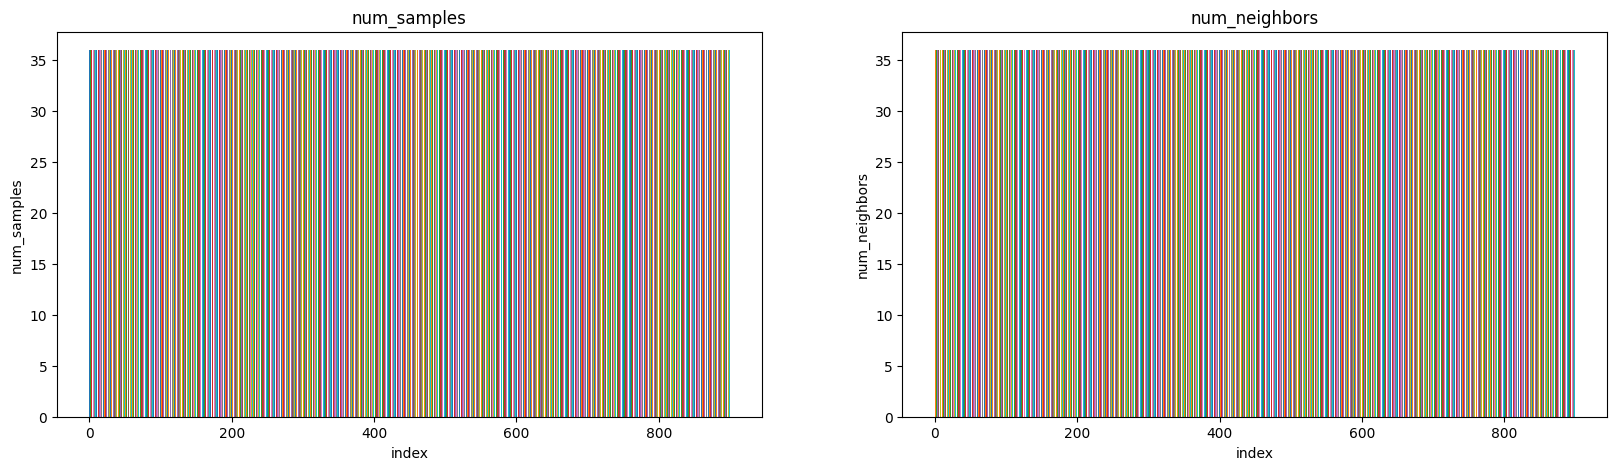

In [44]:
d = data[0]
"""samplesの中身を確認"""
print(d['samples'][0:5])
print(type(d['samples']))
print(len(d['samples']),end='\n\n')

"""neighborsの中身を確認"""
print(d['neighbors'][0:5])
print(type(d['neighbors']))
print(len(d['neighbors']),end='\n\n')

"""neighborsの中身を確認"""
print(d['class_name'])
print(type(d['class_name']))
print(len(d['class_name']))


fig,ax = plt.subplots(1,2,figsize=(20,5))
for i in range(len(data)):
    num_samples = len(d['samples'])
    num_neighbors = len(d['neighbors'])
    # axのそれぞれに棒グラフとしてプロット
    ax[0].bar(i,num_samples)
    ax[1].bar(i,num_neighbors)
    # 縦軸，横軸の設定
    ax[0].set_ylabel('num_samples')
    ax[1].set_ylabel('num_neighbors')
    ax[0].set_xlabel('index')
    ax[1].set_xlabel('index')
    ax[0].set_title('num_samples')
    ax[1].set_title('num_neighbors')

plt.show()


# jsonlファイルの作成

クエリをjsonlに書き込む

In [35]:
import json
from pathlib import Path
import os

base_folder = "docs"  # jsonファイルを保存するベースフォルダのパス
os.makedirs(base_folder, exist_ok=True)
jsonl_path = f'./{base_folder}/custom_data.jsonl'

# サンプルの辞書データを作成
sample_data = {
    "class_id": "",
    "class_name": "",
    "name":"",
    "samples": [],
    "neighbors": [],
}

# jsonl形式でファイルに保存
cnt = 1
query_rootpath = Path("/home/data/MIMIC-IT/VI_scraping_data/VI_full_train_query")
query_dirname = [Path(p) for p in query_rootpath.iterdir() if p.is_dir()]

for q_dir in query_dirname:
    for q_sub_dir in q_dir.iterdir():
        # sub_dirにあるファイルを取得
        
        files = [str(p) for p in q_sub_dir.iterdir() if p.is_file()]
        cls_name = q_sub_dir.name
        parent_cls_name = q_dir.name
        sample_data["class_id"] = cnt
        sample_data["class_name"] = cls_name
        sample_data["name"] = parent_cls_name+'+'+cls_name
        sample_data["samples"] = files
        if cnt == 0:
            with open(jsonl_path, "w") as file:
                file.write(json.dumps(sample_data) + "\n")
        else:
            with open(jsonl_path, "a") as file:
                file.write(json.dumps(sample_data) + "\n")
        cnt += 1



neighborsにコンテキストのNoneを書き込む

In [36]:
import json
import os
import glob

context_dir = "/home/data/MIMIC-IT/VI_scraping_data/VI_full_train_context"  # ここにベースディレクトリを指定

# jsonlデータを保持するリスト
jsonl_data = []

with open(jsonl_path, 'r') as f:
    for line in f:
        jsonl_data.append(json.loads(line))
        
# ファイルに追記
for item in jsonl_data:
    name = item["name"]
    target_name = name.split('+')[0] + '+None'
    
    # "class_id"を検索
    target_class_id = None
    for candidate in jsonl_data:
        if candidate["name"] == target_name:
            target_class_id = candidate["class_id"]
            break
    
    # 一致するものが見つからなかった場合
    if target_class_id is None:
        continue
    
    # パスの生成
    path = os.path.join(context_dir, name.split('+')[0].replace('+', '/'), 'None')
    
    # 画像ファイルのリストを取得
    image_files = glob.glob(f"{path}/*.jpg") + glob.glob(f"{path}/*.JPG")
    
    # neighborsに追記
    neighbor = {
        "class_id": target_class_id,
        "name": target_name.split('+')[1],
        "data": image_files
    }
    item["neighbors"].append(neighbor)

# jsonlファイルに保存
with open(jsonl_path, 'w') as f:
    for item in jsonl_data:
        json.dump(item, f)
        f.write('\n')


neighborsにコンテキストの不良品を書き込む（クエリが不良品の場合）

In [37]:
import json
import os
import glob

context_dir = "/home/data/MIMIC-IT/VI_scraping_data/VI_full_train_context"  # ここにベースディレクトリを指定

# jsonlデータを保持するリスト
jsonl_data = []

with open(jsonl_path, 'r') as f:
    for line in f:
        jsonl_data.append(json.loads(line))
        
# 新たな追記処理
for item in jsonl_data:
    name = item["name"]
    split_name = name.split('+')
    
    # "+"でsplitした[1]が"None"でない場合のみ処理
    if split_name[1] != "None":
        new_name = name.replace('+', '/')
        class_id = item["class_id"]
        name_part = split_name[1]
        
        # パスの生成
        path = os.path.join(context_dir, new_name)
        
        # 画像ファイルのリストを取得
        image_files = glob.glob(f"{path}/*.jpg") + glob.glob(f"{path}/*.JPG")
        
        # neighborsに追記
        neighbor = {
            "class_id": class_id,
            "name": name_part,
            "data": image_files
        }
        item["neighbors"].append(neighbor)

# jsonlファイルに保存
with open(jsonl_path, 'w') as f:
    for item in jsonl_data:
        json.dump(item, f)
        f.write('\n')

neighborsにコンテキストの不良品を書き込む（クエリが不良品の場合）

In [38]:
import json
import os
import glob

context_dir = "/home/data/MIMIC-IT/VI_scraping_data/VI_full_train_context"  # ここにベースディレクトリを指定

# jsonlデータを保持するリスト
jsonl_data = []

with open(jsonl_path, 'r') as f:
    for line in f:
        jsonl_data.append(json.loads(line))

# サブフォルダに対して新たな追記処理
for item in jsonl_data:
    name = item["name"]
    split_name = name.split('+')
    
    # "+"でsplitした[1]が"None"の場合のみ処理
    if split_name[1] == "None":
        subfolder_base = os.path.join(context_dir, split_name[0])
        
        # サブフォルダの存在確認と名前の取得
        for subfolder_name in os.listdir(subfolder_base):
            if subfolder_name != "None":
                new_key = f"{split_name[0]}+{subfolder_name}"
                
                # 対応する"class_id"と"name"を取得
                target_class_id = None
                for candidate in jsonl_data:
                    if candidate["name"] == new_key:
                        target_class_id = candidate["class_id"]
                        break
                
                if target_class_id is None:
                    continue
                
                # 画像ファイルのパスを取得
                image_path = os.path.join(subfolder_base, subfolder_name)
                image_files = glob.glob(f"{image_path}/*.jpg") + glob.glob(f"{image_path}/*.JPG")
                
                # neighborsに追記
                neighbor = {
                    "class_id": target_class_id,
                    "name": subfolder_name,
                    "data": image_files
                }
                item["neighbors"].append(neighbor)

# jsonlファイルに保存
with open(jsonl_path, 'w') as f:
    for item in jsonl_data:
        json.dump(item, f)
        f.write('\n')
